Implement Time Series Forecasting

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Upload dataset
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your file

Saving exp7_airlinepassenger.csv to exp7_airlinepassenger.csv


In [3]:
# Read the dataset from Excel (.xlsx) format
import pandas as pd
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

In [4]:
# Convert the 'Month' column to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Set the 'Month' column as the index
df.set_index('Month', inplace=True)

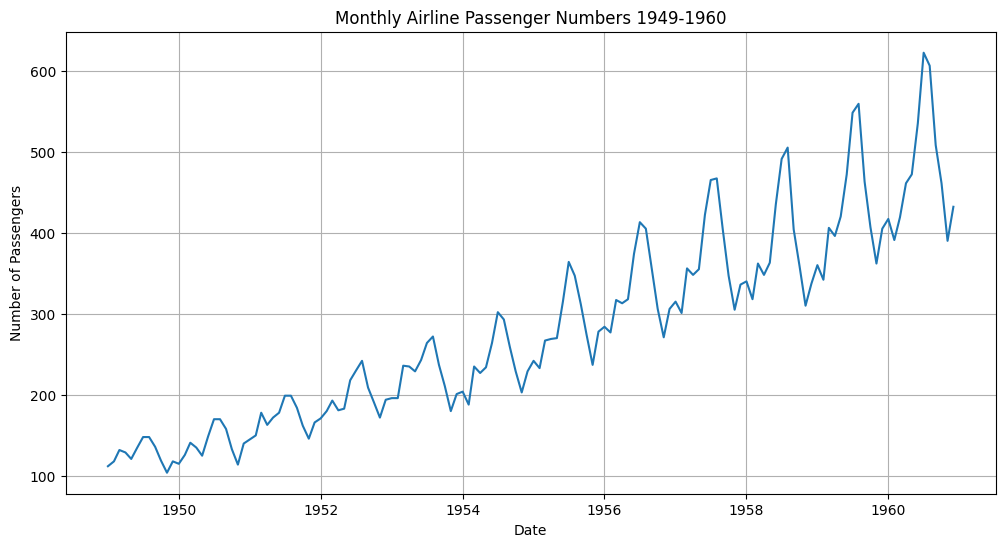

In [5]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'])
plt.title('Monthly Airline Passenger Numbers 1949-1960')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

<Figure size 1200x1000 with 0 Axes>

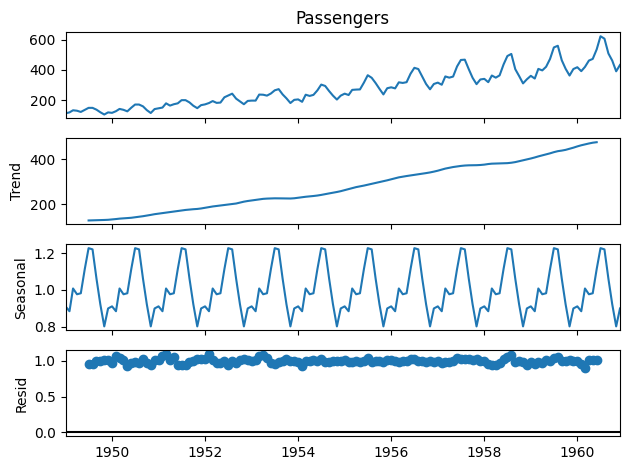

In [6]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

# Plot the decomposition
fig = plt.figure(figsize=(12, 10))
fig = decomposition.plot()
plt.tight_layout()
plt.show()

In [7]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # If p-value is less than 0.05, we can reject the null hypothesis and say that the series is stationary
    if dftest[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")

check_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The series is not stationary


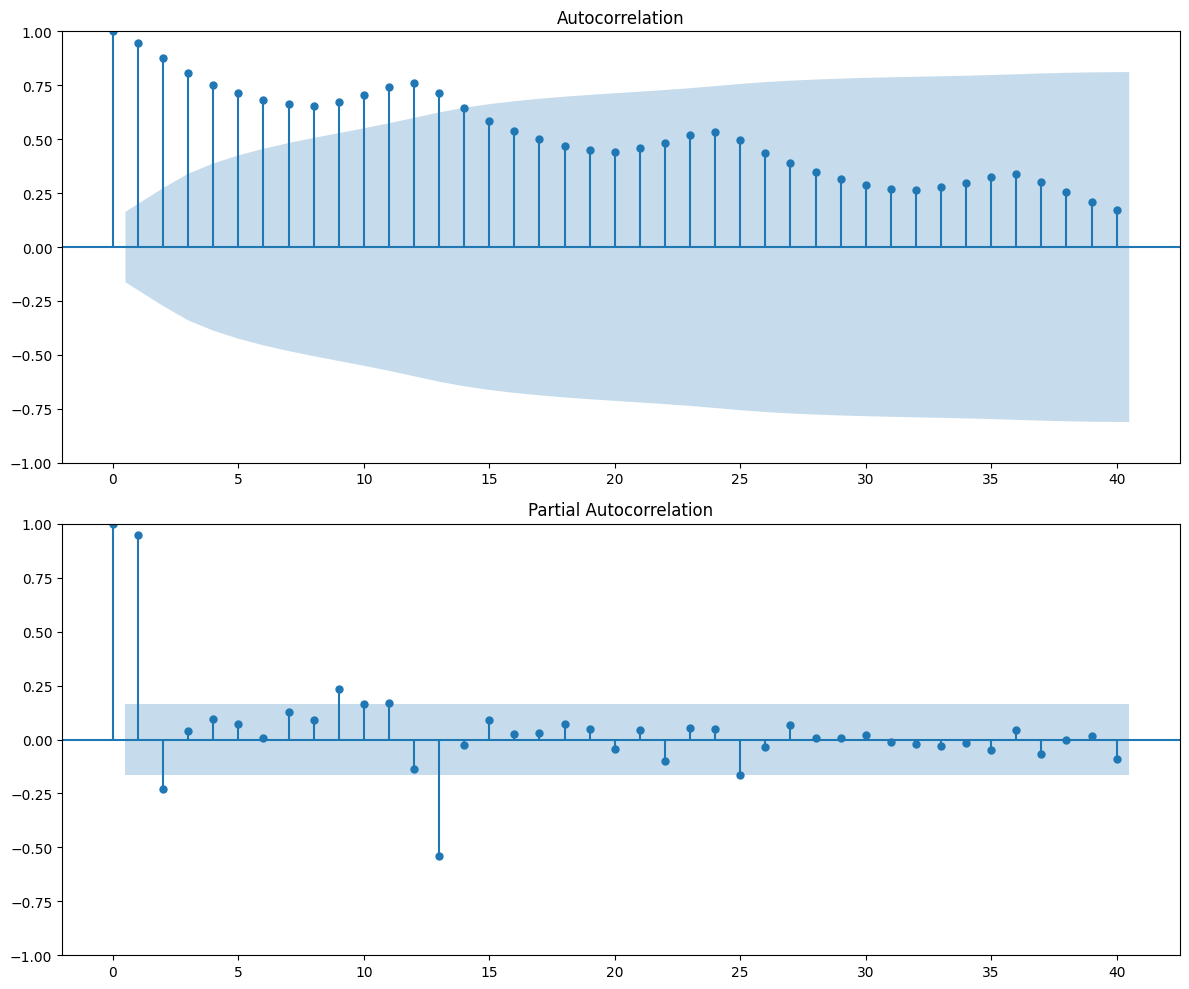

In [9]:
# Plot ACF and PACF to determine the order of ARIMA model
plt.figure(figsize=(12, 10))
plt.subplot(211)
plot_acf(df['Passengers'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(df['Passengers'], ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

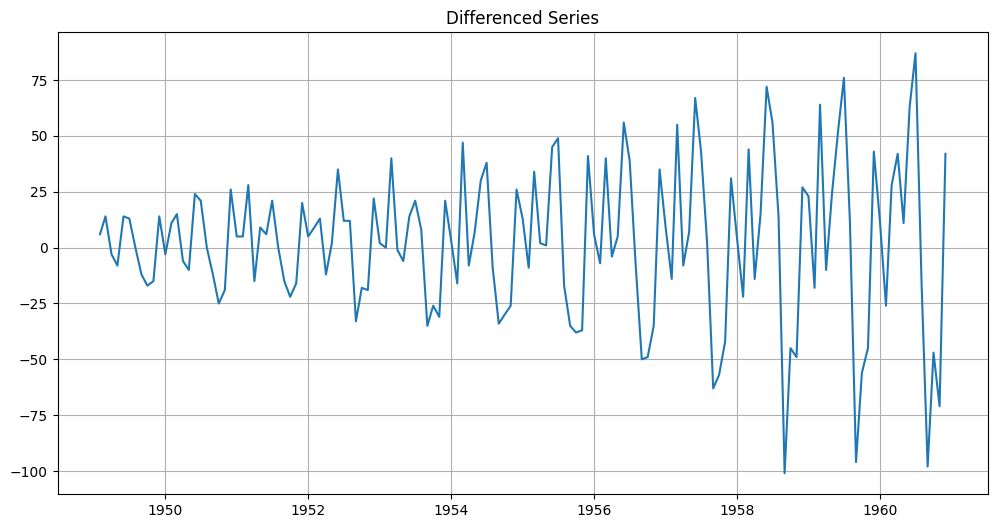

In [10]:
# If the series is not stationary, apply differencing
df_diff = df.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_diff)
plt.title('Differenced Series')
plt.grid(True)
plt.show()

In [12]:
# Check stationarity after differencing
check_stationarity(df_diff['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The series is not stationary


In [13]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [14]:
# Fit ARIMA model (p, d, q)
# p: number of lag observations (AR order)
# d: degree of differencing
# q: size of the moving average window (MA order)
# Based on ACF and PACF plots, we'll try ARIMA(2,1,2) as an example
model = ARIMA(train['Passengers'], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -523.758
Date:                Mon, 21 Apr 2025   AIC                           1057.516
Time:                        10:00:43   BIC                           1071.197
Sample:                    01-01-1949   HQIC                          1063.069
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3280      0.145      2.268      0.023       0.045       0.611
ar.L2          0.2521      0.165      1.528      0.126      -0.071       0.575
ma.L1         -0.0125      0.109     -0.114      0.9

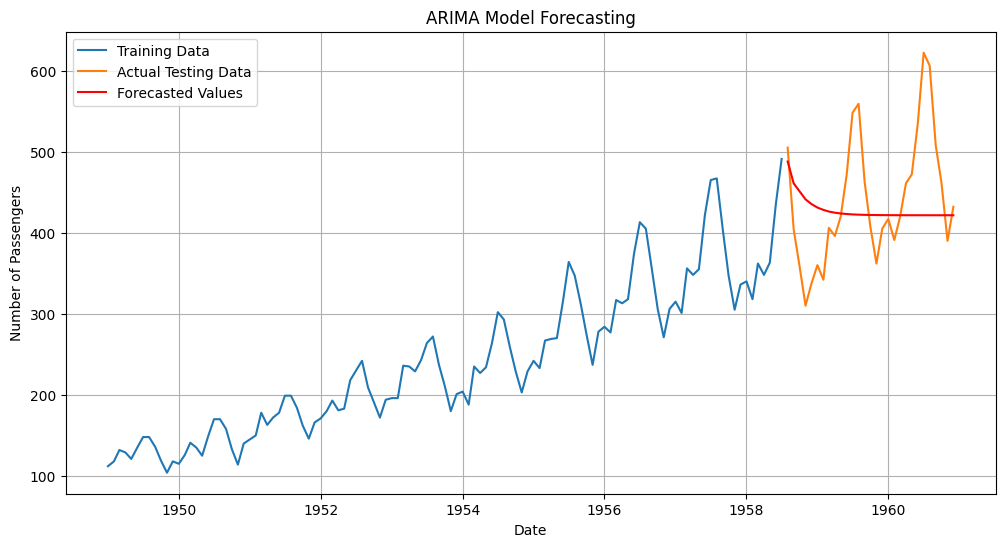

In [15]:
# Plot the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Training Data')
plt.plot(test.index, test['Passengers'], label='Actual Testing Data')
plt.plot(test.index, forecast, label='Forecasted Values', color='red')
plt.title('ARIMA Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Calculate RMSE for the forecast
rmse = sqrt(mean_squared_error(test['Passengers'], forecast))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean of Test Data: {test["Passengers"].mean()}')
print(f'RMSE as percentage of mean: {rmse / test["Passengers"].mean() * 100:.2f}%')

# Let's also try a simpler model: Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit Simple Exponential Smoothing model
ses_model = SimpleExpSmoothing(train['Passengers']).fit()
ses_forecast = ses_model.forecast(len(test))

Root Mean Squared Error: 82.51301138301066
Mean of Test Data: 440.3103448275862
RMSE as percentage of mean: 18.74%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


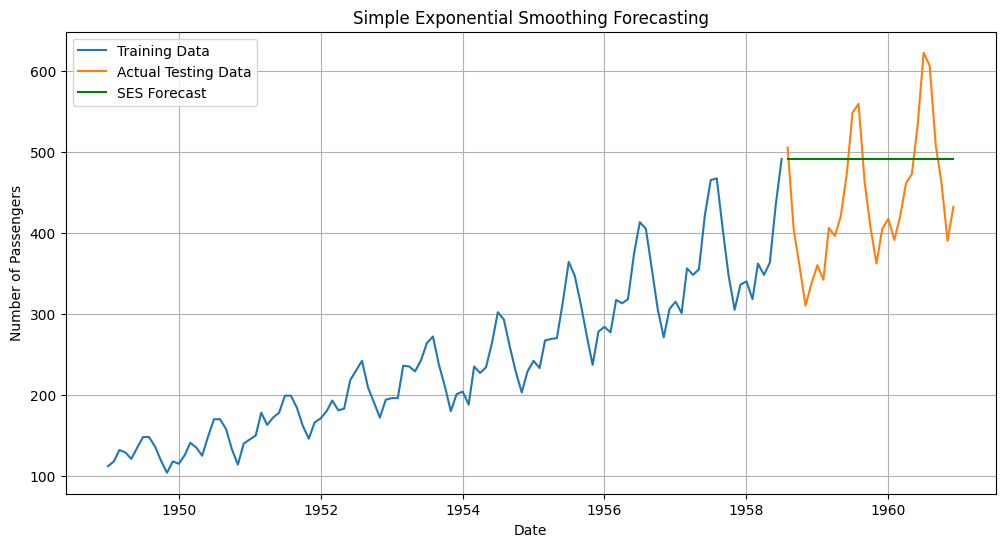

In [17]:
# Plot SES forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Training Data')
plt.plot(test.index, test['Passengers'], label='Actual Testing Data')
plt.plot(test.index, ses_forecast, label='SES Forecast', color='green')
plt.title('Simple Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calculate RMSE for SES forecast
ses_rmse = sqrt(mean_squared_error(test['Passengers'], ses_forecast))
print(f'SES Root Mean Squared Error: {ses_rmse}')
print(f'SES RMSE as percentage of mean: {ses_rmse / test["Passengers"].mean() * 100:.2f}%')

# Let's also try Holt-Winters model for exponential smoothing with trend and seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
hw_model = ExponentialSmoothing(train['Passengers'],
                               seasonal_periods=12,
                               trend='add',
                               seasonal='add').fit()
hw_forecast = hw_model.forecast(len(test))

SES Root Mean Squared Error: 92.98086667646439
SES RMSE as percentage of mean: 21.12%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


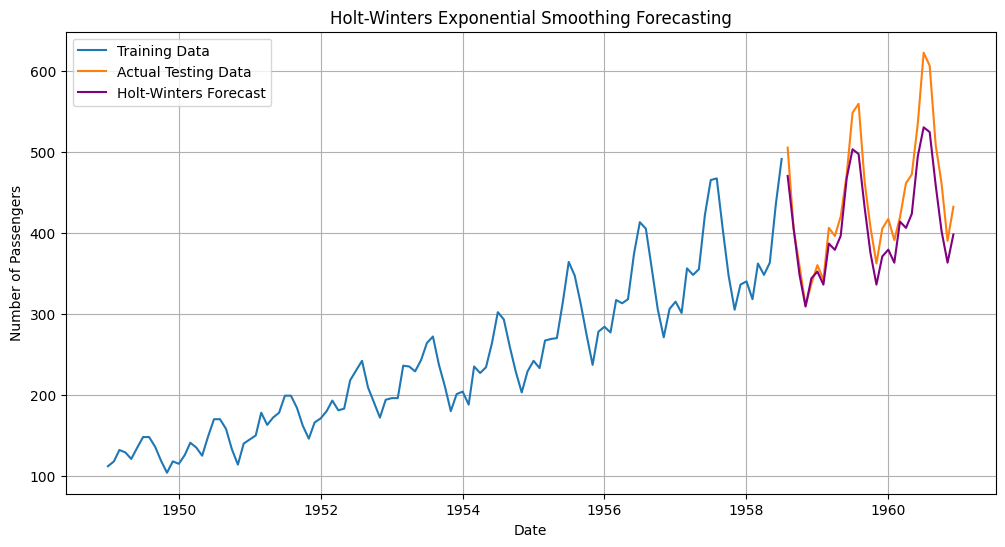

In [20]:
# Plot Holt-Winters forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Training Data')
plt.plot(test.index, test['Passengers'], label='Actual Testing Data')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='purple')
plt.title('Holt-Winters Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Calculate RMSE for Holt-Winters forecast
hw_rmse = sqrt(mean_squared_error(test['Passengers'], hw_forecast))
print(f'Holt-Winters Root Mean Squared Error: {hw_rmse}')
print(f'Holt-Winters RMSE as percentage of mean: {hw_rmse / test["Passengers"].mean() * 100:.2f}%')

Holt-Winters Root Mean Squared Error: 39.26061311965583
Holt-Winters RMSE as percentage of mean: 8.92%


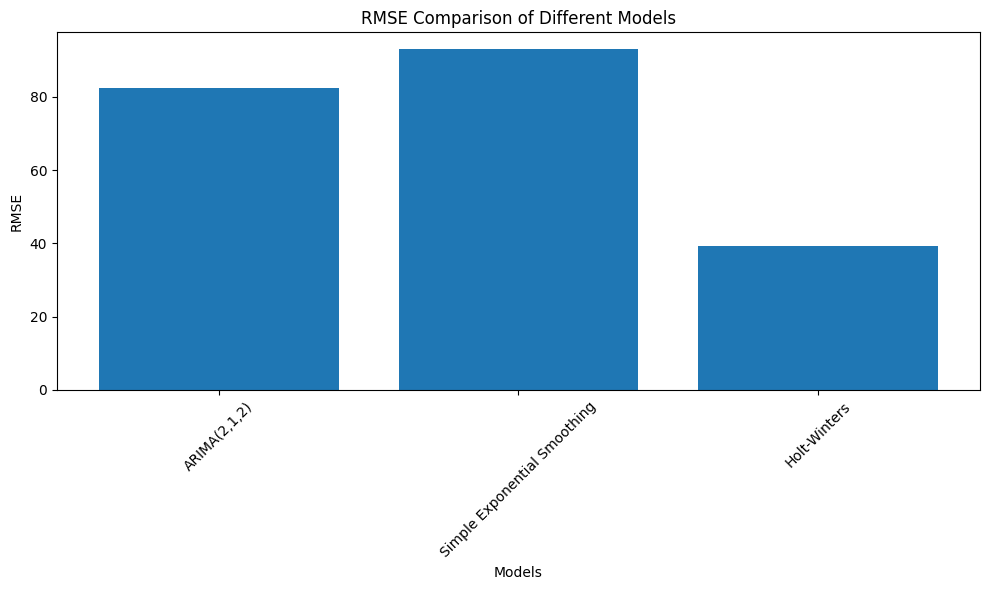

In [22]:
# Compare all models
models = ['ARIMA(2,1,2)', 'Simple Exponential Smoothing', 'Holt-Winters']
rmse_values = [rmse, ses_rmse, hw_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison of Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

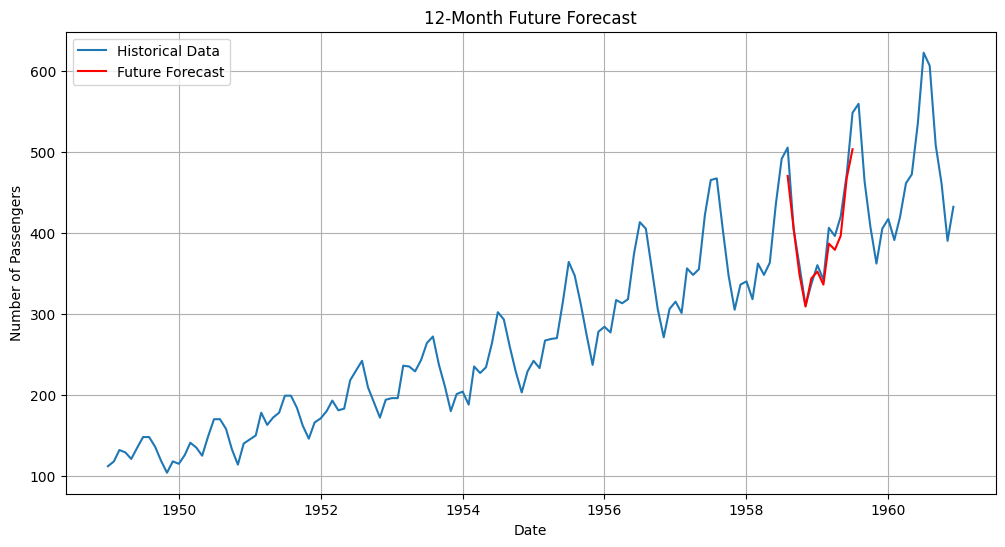

Future forecast for the next 12 months:
1958-08-01    470.044048
1958-09-01    404.416508
1958-10-01    348.120994
1958-11-01    308.939048
1958-12-01    343.702150
1959-01-01    352.061126
1959-02-01    335.999724
1959-03-01    386.616003
1959-04-01    378.918688
1959-05-01    396.227240
1959-06-01    467.407139
1959-07-01    502.927677
Freq: MS, dtype: float64


In [23]:
# Final forecast for future periods (next 12 months)
# Using the best model (you can choose based on lowest RMSE)
# For this example, let's use the Holt-Winters model
future_forecast = hw_model.forecast(12)

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Historical Data')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='red')
plt.title('12-Month Future Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Print the future forecast values
print("Future forecast for the next 12 months:")
print(future_forecast)